# Environment Setup and Data Loading Preparation

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import ast
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import math
import matplotlib.pyplot as plt
import joblib

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  5 00:45:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 179.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# must be 2.11.0
tf.__version__

'2.19.0'

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the data zip file to the local disk (/content/)
!cp -rf '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/data.zip' /content/local_data

In [ ]:
import os

file_path = '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/data.zip'
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

The file '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/data.zip' exists.


In [ ]:
import os

file_path = '/content/local_data/data.zip'
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

The file '/content/local_data/data.zip' does not exist.


In [ ]:
# Unzip the data
!rm -rf /content/local_data/data
!unzip -o '/content/local_data/data.zip' -d '/content/local_data/data'

unzip:  cannot find or open /content/local_data/data.zip, /content/local_data/data.zip.zip or /content/local_data/data.zip.ZIP.


# Data Loading and Initial Preprocessing

In [ ]:
filepath = '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/filtered_data.json'

df = pd.read_json(
    filepath,
    dtype={'total_mass': 'float64'}
)
df.head(3)

id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1561662216      300.794281       193.0  12.387489    28.21829   
1  dish_1561662216      300.794281       193.0  12.387489    28.21829   
2  dish_1561662216      300.794281       193.0  12.387489    28.21829   

   total_protein                             label  \
0       18.63397  [brown rice, pork, mixed greens]   
1       18.63397  [brown rice, pork, mixed greens]   
2       18.63397  [brown rice, pork, mixed greens]   

                                       image_link split  
0  ./data/dish_1561662216/camera_A_frame_002.jpeg  test  
1  ./data/dish_1561662216/camera_D_frame_002.jpeg  test  
2  ./data/dish_1561662216/camera_C_frame_002.jpeg  test

In [ ]:
df.dtypes

id                 object
total_calories    float64
total_mass        float64
total_fat         float64
total_carb        float64
total_protein     float64
label              object
image_link         object
split              object
dtype: object

In [ ]:
directory = '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/data/'
df['image_link'] = df['image_link'].apply(lambda x: os.path.join(directory, x.replace('./data/', '', 1)))

In [ ]:
df.head(3)

id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1561662216      300.794281       193.0  12.387489    28.21829   
1  dish_1561662216      300.794281       193.0  12.387489    28.21829   
2  dish_1561662216      300.794281       193.0  12.387489    28.21829   

   total_protein                             label  \
0       18.63397  [brown rice, pork, mixed greens]   
1       18.63397  [brown rice, pork, mixed greens]   
2       18.63397  [brown rice, pork, mixed greens]   

                                          image_link split  
0  /content/drive/My Drive/research/model-v2/nutr...  test  
1  /content/drive/My Drive/research/model-v2/nutr...  test  
2  /content/drive/My Drive/research/model-v2/nutr...  test

In [ ]:
df['image_link'][0]

'/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/data/dish_1561662216/camera_A_frame_002.jpeg'

# Feature Engineering

### Generate Portion Independent data

In [ ]:
df_portion_independent = df.copy()
df_portion_independent['protein_scaled'] = df_portion_independent['total_protein'] / df_portion_independent['total_mass']
df_portion_independent['fat_scaled'] = df_portion_independent['total_fat'] / df_portion_independent['total_mass']
df_portion_independent['carbs_scaled'] = df_portion_independent['total_carb'] / df_portion_independent['total_mass']
df_portion_independent.head(3)


id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1561662216      300.794281       193.0  12.387489    28.21829   
1  dish_1561662216      300.794281       193.0  12.387489    28.21829   
2  dish_1561662216      300.794281       193.0  12.387489    28.21829   

   total_protein                             label  \
0       18.63397  [brown rice, pork, mixed greens]   
1       18.63397  [brown rice, pork, mixed greens]   
2       18.63397  [brown rice, pork, mixed greens]   

                                          image_link split  protein_scaled  \
0  /content/drive/My Drive/research/model-v2/nutr...  test        0.096549   
1  /content/drive/My Drive/research/model-v2/nutr...  test        0.096549   
2  /content/drive/My Drive/research/model-v2/nutr...  test        0.096549   

   fat_scaled  carbs_scaled  
0    0.064184      0.146209  
1    0.064184      0.146209  
2    0.064184      0.146209

In [ ]:
df_portion_independent[['protein_scaled', 'fat_scaled', 'carbs_scaled']].describe()

protein_scaled    fat_scaled  carbs_scaled
count    58296.000000  58296.000000  58296.000000
mean         0.075062      0.065068      0.100792
std          0.077780      0.093668      0.081684
min          0.003000      0.000000      0.000000
25%          0.018000      0.003156      0.045378
50%          0.047940      0.037610      0.084102
75%          0.109700      0.088341      0.135543
max          0.566642      0.540000      1.121761

### Data Normalization

In [ ]:
def scale(df, col):
    df = df.copy()
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return scaler, df

calorie_scaler, df = scale(df, 'total_calories')
mass_scaler, df = scale(df, 'total_mass')
fat_scaler, df = scale(df, 'total_fat')
carb_scaler, df = scale(df, 'total_carb')
protein_scaler, df = scale(df, 'total_protein')

In [ ]:
joblib.dump(calorie_scaler, '/content/drive/My Drive/research/model-v2/nutrition5k/nutrition_model/scalers/calorie_scaler.save')
joblib.dump(mass_scaler, '/content/drive/My Drive/research/model-v2/nutrition5k/nutrition_model/mass_scaler.save')
joblib.dump(fat_scaler, '/content/drive/My Drive/research/model-v2/nutrition5k/nutrition_model/fat_scaler.save')
joblib.dump(carb_scaler, '/content/drive/My Drive/research/model-v2/nutrition5k/nutrition_model/carb_scaler.save')
joblib.dump(protein_scaler, '/content/drive/My Drive/research/model-v2/nutrition5k/nutrition_model/protein_scaler.save')

['/content/drive/My Drive/research/model-v2/nutrition5k/nutrition_model/protein_scaler.save']

In [ ]:
df.head(3)

id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1561662216        0.348849    0.311987   0.182478    0.187726   
1  dish_1561662216        0.348849    0.311987   0.182478    0.187726   
2  dish_1561662216        0.348849    0.311987   0.182478    0.187726   

   total_protein                             label  \
0       0.154563  [brown rice, pork, mixed greens]   
1       0.154563  [brown rice, pork, mixed greens]   
2       0.154563  [brown rice, pork, mixed greens]   

                                          image_link split  
0  /content/drive/My Drive/research/model-v2/nutr...  test  
1  /content/drive/My Drive/research/model-v2/nutr...  test  
2  /content/drive/My Drive/research/model-v2/nutr...  test

# Train Test Split

In [ ]:
def split_data(df):
    X_train = df[df['split'] == 'train']
    X_test = df[df['split'] == 'test']
    return X_train, X_test

In [ ]:
X_train_portion_independent, X_test_portion_independent = split_data(df_portion_independent)
X_train_portion_independent.shape, X_test_portion_independent.shape

((48619, 12), (9677, 12))

In [ ]:
image_size = 320
batch_size = 256
input_shape = (image_size, image_size, 3)
directory = '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/data/'
x_col = 'image_link'
y_col = ['total_protein', 'total_fat', 'total_carb', 'total_mass']
y_col_portion_independent = ['protein_scaled', 'fat_scaled', 'carbs_scaled']

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    brightness_range=(1, 1.5),
    fill_mode='nearest',
)

In [ ]:
def get_base_generator(df, y_col, shuffle=True):
    return image_generator.flow_from_dataframe(
        df,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=(image_size, image_size),
        color_mode='rgb',
        class_mode='raw',
        shuffle=shuffle,
    )

def get_generator(source_generator, portion_independent=False):
    while True:
        X, y = next(source_generator)
        length = y.shape[0]
        protein = y[:, 0].reshape(length, 1)
        fat = y[:, 1].reshape(length, 1)
        carbs = y[:, 2].reshape(length, 1)
        out = {
            'protein': protein,
            'fat': fat,
            'carbs': carbs,
        }
        if not portion_independent:
            mass = y[:, 3].reshape(length, 1)
            out['mass'] = mass
        yield X, out

In [ ]:
train_generator_portion_independent = get_base_generator(X_train_portion_independent, y_col_portion_independent)
train_gen_portion_independent = get_generator(train_generator_portion_independent, True)

Found 46011 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2608 invalid image filename(s) in x_col="image_link". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_generator_portion_independent = get_base_generator(X_test_portion_independent, y_col_portion_independent, False)
test_gen_portion_independent = get_generator(test_generator_portion_independent, True)

Found 9024 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 653 invalid image filename(s) in x_col="image_link". These filename(s) will be ignored.
  warnings.warn(


# Loading Image Recognition Model




In [ ]:
# 1. Copy the data folder to the local disk (/content/)
# Unzip the data
!cp -rf '/content/drive/My Drive/research/model-v2/nutrition5k/models/ingredient_model_EfficientNetV2B0.keras' /content/local_data

# Create nutrients prediction model

In [ ]:
def create_base_model():
    base_model = tf.keras.models.load_model('/content/drive/My Drive/research/model-v2/nutrition5k/models/ingredient_model_EfficientNetV2B0.keras')
    for layer in base_model.layers:
        layer.trainable = False
    return base_model

In [ ]:
base_model = create_base_model()
base_model.summary()

In [ ]:
def create_branch(x, name):
    x = tf.keras.layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
        name=f'{name}_dense',
    )(x)
    x = tf.keras.layers.Dropout(0.5, name=f'{name}_dropout')(x)
    x = tf.keras.layers.Dense(1, name=name)(x)
    return x

def create_multi_task_model(base_model, portion_independent=False):
    x = base_model.layers[-65].output
    x = tf.keras.layers.Flatten(name='flatten_base_model')(x)

    protein_branch = create_branch(x, name='protein')
    fat_branch = create_branch(x, name='fat')
    carbs_branch = create_branch(x, name='carbs')
    outputs = {
        'protein': protein_branch,
        'fat': fat_branch,
        'carbs': carbs_branch,
    }

    if not portion_independent:
        mass_branch = create_branch(x, name='mass')
        outputs['mass'] = mass_branch

    model = tf.keras.Model(
        inputs=base_model.input,
        outputs=outputs,
    )
    return model

In [ ]:
def create_callbacks():
    def scheduler(epoch, lr):
        if epoch < 4:
            return float(lr)
        else:
            return float(lr * tf.math.exp(-0.1))
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    return [
        lr_scheduler,
    ]

In [ ]:
learning_rate = 0.00008

def compile_model(model, portion_independent=False):
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    losses = {
        'protein': tf.keras.losses.MeanAbsoluteError(),
        'fat': tf.keras.losses.MeanAbsoluteError(),
        'carbs': tf.keras.losses.MeanAbsoluteError(),
    }
    if not portion_independent:
        losses['mass'] = tf.keras.losses.MeanAbsoluteError()
    model.compile(
        optimizer=opt,
        loss=losses,
    )
    return model

In [ ]:
def save_history(history, path):
    df = pd.DataFrame(history.history)
    df.to_json(path)

In [ ]:
def plot_key(history, key, name):
    train_loss = history.history[key]
    val_loss = history.history[f'val_{key}']
    plt.title(name)
    plt.plot(train_loss, label='Training')
    plt.plot(val_loss, label='Validation')
    plt.grid()
    plt.legend()
    plt.show()

def plot_losses(history, portion_independent=False):
    plot_key(history, 'loss', 'Overall loss')
    plot_key(history, 'protein_loss', 'Protein')
    plot_key(history, 'carbs_loss', 'Carbs')
    plot_key(history, 'fat_loss', 'Fat')
    if not portion_independent:
        plot_key(history, 'mass_loss', 'Mass')

In [ ]:
portion_independent = create_multi_task_model(base_model, True)
portion_independent.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 320, 320,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 320, 320,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 160, 160,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 160, 160,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 160, 160,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 160, 160,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 160, 160,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 160, 160,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 80, 80,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 80, 80,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 80, 80,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 80, 80,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 80, 80,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 80, 80,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 80, 80,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 80, 80,    │          0 │ block2b_expand_b

 Total params: 25,729,939 (98.15 MB)

 Trainable params: 22,118,787 (84.38 MB)

 Non-trainable params: 3,611,152 (13.78 MB)

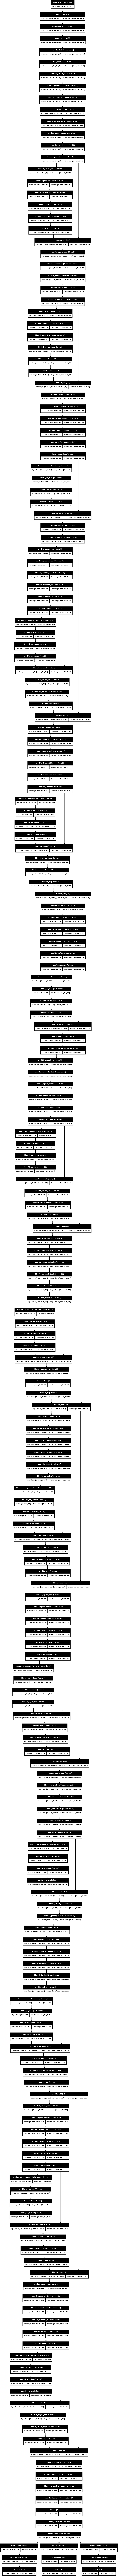

In [ ]:
tf.keras.utils.plot_model(portion_independent, show_shapes=True, show_layer_names=True, to_file='portion_independent.png')


In [ ]:
portion_independent = compile_model(portion_independent, True)

# Train the Portion Independent Model for predicting nutrients

In [ ]:
callbacks = create_callbacks()
epochs = 10
steps_per_epoch = math.ceil(len(X_train_portion_independent) / batch_size)
val_steps_per_epoch = math.ceil(len(X_test_portion_independent) / batch_size)

history_pi = portion_independent.fit(
    train_gen_portion_independent,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
    validation_data=test_gen_portion_independent,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks,
)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - carbs_loss: 0.3374 - fat_loss: 0.4189 - loss: 2.0413 - protein_loss: 0.4578 - val_carbs_loss: 0.0643 - val_fat_loss: 0.0548 - val_loss: 0.9612 - val_protein_loss: 0.0512 - learning_rate: 8.0000e-05
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 186s 983ms/step - carbs_loss: 0.0602 - fat_loss: 0.0488 - loss: 0.9360 - protein_loss: 0.0483 - val_carbs_loss: 0.0338 - val_fat_loss: 0.0369 - val_loss: 0.8522 - val_protein_loss: 0.0386 - learning_rate: 8.0000e-05
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 185s 980ms/step - carbs_loss: 0.0494 - fat_loss: 0.0475 - loss: 0.8699 - protein_loss: 0.0421 - val_carbs_loss: 0.0342 - val_fat_loss: 0.0382 - val_loss: 0.8022 - val_protein_loss: 0.0372 - learning_rate: 8.0000e-05
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 181s 960ms/step - carbs_loss: 0.0454 - fat_loss: 0.0439 - loss: 0.8097 - protein_loss: 0.0410 - val_carbs_loss: 0.0347 - val_fat_loss: 0.0357 - val_loss: 0.7352 - val_protein_loss: 0.0255 - learn

In [ ]:
portion_independent.save('/content/drive/My Drive/research/model-v2/nutrition5k/models/portion_independent.keras')

In [ ]:
save_history(history_pi, '/content/drive/My Drive/research/model-v2/nutrition5k/models/portion_independent_history.json')

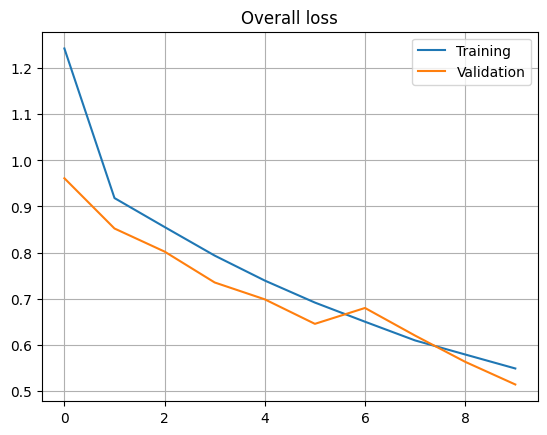

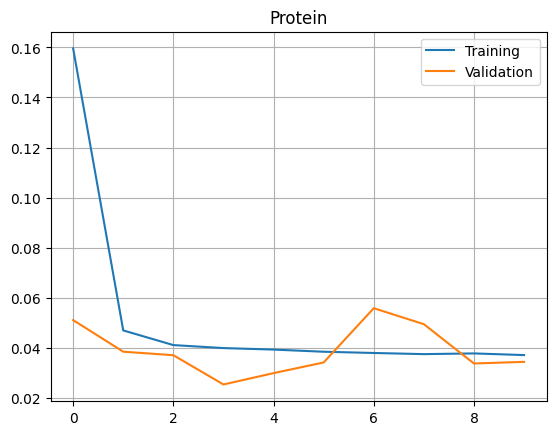

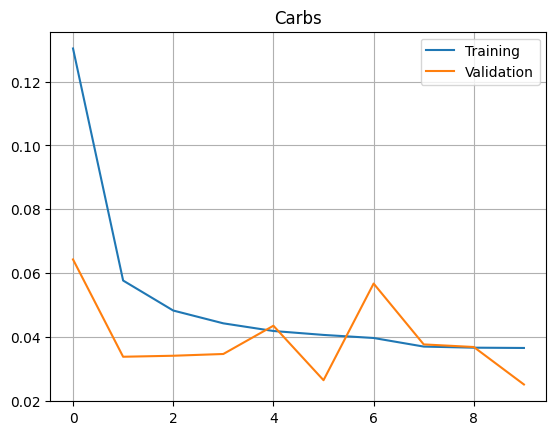

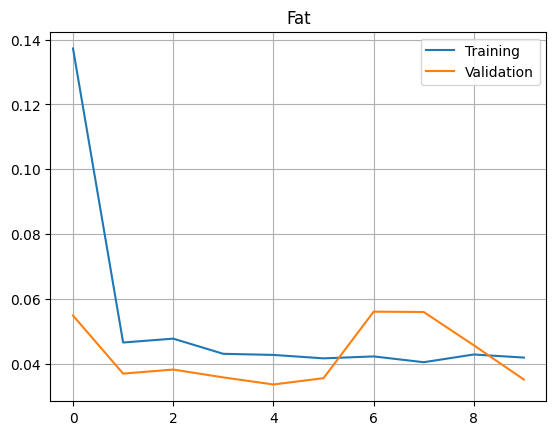

In [ ]:
plot_losses(history_pi, True)

In [ ]:
portion_independent = tf.keras.models.load_model('/content/drive/My Drive/research/model-v2/nutrition5k/models/portion_independent.keras')
image_model = tf.keras.models.load_model('/content/drive/My Drive/research/model-v2/nutrition5k/models/ingredient_model_EfficientNetV2B0.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 496 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
classes = pd.read_json('/content/drive/My Drive/research/model-v2/nutrition5k/image_model/class_encoding.json')
class_map = dict(zip(classes['idx'], classes['ingr']))

In [ ]:
def calories_from_macro(protein, carbs, fat):
    return protein * 4 + carbs * 4 + fat * 9

def make_image_prediction(img, model):
    predictions = model.predict(img)[0]
    indices = np.argsort(predictions)[::-1][:5]
    probs = [predictions[i] for i in indices]
    predicted_labels = [class_map[i] for i in indices]
    return predicted_labels, probs


def make_portion_independent_prediction(img, model, total_mass):
    predictions = model.predict(img)
    protein = predictions['protein'][0][0] * total_mass
    fat = predictions['fat'][0][0] * total_mass
    carbs = predictions['carbs'][0][0] * total_mass
    calories = calories_from_macro(
        protein=protein,
        carbs=carbs,
        fat=fat,
    )
    return {
        'predictions': predictions,
        'protein': protein,
        'fat': fat,
        'carbs': carbs,
        'calories': calories,
        'mass': total_mass,
    }

def random_img():
    item = df[df['split'] == 'test'].sample(1)
    img = tf.keras.utils.load_img(f"{item['image_link'].values[0]}")
    return item, img

### Testing model (for a random image)

In [ ]:
item, img = random_img()

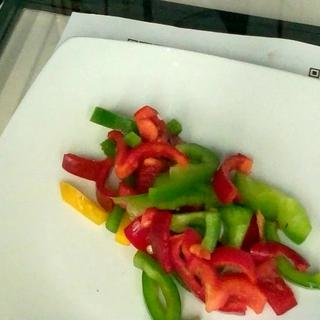

In [ ]:
img

In [ ]:
x = np.array(img)
x = np.expand_dims(x, axis=0)

In [ ]:
preds, probs = make_image_prediction(x, image_model)
pd.DataFrame({
    'prediction': preds,
    'probability': probs
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


prediction  probability
0      bell peppers     0.999710
1  brussels sprouts     0.001196
2           berries     0.001137
3          tomatoes     0.001009
4             bacon     0.000821

In [ ]:
print('Actual:', item['label'].values[0])

Actual: ['bell peppers']


In [ ]:
df_original = pd.read_json(
    '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/preprocessed_data.json',
    dtype={'total_mass': 'float64'}
)

In [ ]:
original_item = df_original[df_original['id'] == item['id'].values[0]].iloc[0]

In [ ]:
def evaluate_item(predicted, actual):
    return pd.DataFrame([
        [
            predicted['protein'],
            actual['total_protein'],
        ],
        [
            predicted['fat'],
            actual['total_fat'],
        ],
        [
            predicted['carbs'],
            actual['total_carb'],
        ],
        [
            predicted['calories'],
            actual['total_calories'],
        ],
        [
            predicted['mass'],
            actual['total_mass'],
        ]
    ], ['protein', 'fat', 'carbs', 'calories', 'mass'], columns=['predicted', 'actual'])

In [ ]:
portion_independent_output = make_portion_independent_prediction(x, portion_independent, original_item['total_mass'])
evaluate_item(portion_independent_output, original_item)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


predicted  actual
protein    1.839636   1.520
fat        1.367093   0.152
carbs      6.020094   6.840
calories  43.742759  30.400
mass      76.000000  76.000